## import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import pickle

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## ResNet Block

In [3]:
def conv2d(channel=64, kernel_size=(3,3), strides=1, block_num=0, cnn_num=0):
    def f(x):
        x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=kernel_size,
                strides=strides,
                kernel_initializer='he_normal',
                padding='same',
#                 name=f'block{block_num}_conv{cnn_num}'
            )(x)
        return x
    return f

In [4]:
def conv_bn_relu(channel=64, kernel_size=(3,3), strides=1, block_num=0, cnn_num=0):
    conv = conv2d(channel=channel, 
                   kernel_size=kernel_size, 
                   strides=strides,
                   block_num=block_num,
                   cnn_num=cnn_num)
    def f(x):
        x = conv(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

        return x
    return f

In [5]:
def shortcut(channel=64, strides=1, block_num=0, cnn_num=0):
    short = conv2d(channel=channel, 
                   kernel_size=(1,1),
                   strides=strides,
                   block_num=block_num,
                   cnn_num=cnn_num)
    def f(x):
        if x.shape[-1] != channel:
            x = short(x)
            x = keras.layers.BatchNormalization()(x)
        
        return x
    return f

In [6]:
def basic_block(channel=64, block_num=0, cnn_num=0, is_shortcut=True):
    if block_num != 0 and cnn_num == 0:
        strides = 2
    else:
        strides = 1

    conv1 = conv_bn_relu(channel=channel,
                         strides=strides,
                         block_num=block_num,
                         cnn_num=cnn_num)
    conv2 = conv2d(channel=channel,
                   block_num=block_num,
                   cnn_num=cnn_num)
    short = shortcut(channel=channel, strides=strides)

    def f(x):
        skip_connection = short(x)
        x = conv1(x)
        x = conv2(x)
        x = keras.layers.BatchNormalization()(x)
        if is_shortcut:
            x += skip_connection
        x = keras.layers.ReLU()(x)
        
        return x

    return f

In [7]:
def bottleneck_block(channel=64, block_num=0, cnn_num=0, is_shortcut=True):
    if block_num != 0 and cnn_num == 0:
        strides = 2
    else:
        strides = 1
        
    conv1 = conv_bn_relu(channel=channel, 
                          kernel_size=(1, 1), 
                          strides=strides,
                          block_num=block_num,
                          cnn_num=cnn_num)
    conv2 = conv_bn_relu(channel=channel, 
                          block_num=block_num,
                          cnn_num=cnn_num)
    conv3 = conv2d(channel=channel*4, 
                   kernel_size=(1, 1), 
                   block_num=block_num,
                   cnn_num=cnn_num)
    short = shortcut(strides=strides, channel=channel*4)

    def f(x):
        skip_connection = short(x)
        x = conv1(x)
        x = conv2(x)
        x = conv3(x)
        x = keras.layers.BatchNormalization()(x)
        if is_shortcut:
            x += skip_connection
        x = keras.layers.ReLU()(x)
        
        return x

    return f

In [8]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                       channel=64,
                       block_num=0,
                       cnn_num=1,
                       block_type='residual'
                      ):
    assert block_type in ['plain', 'residual', 'bottleneck']
    # 입력 레이어
    x = input_layer
    
    if x.shape[-1] == 3:
        x = conv_bn_relu(kernel_size=(7, 7), strides=2, block_num=0, cnn_num=0)(x)
        # Max Pooling 레이어
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name='block0_pooling'
        )(x)

    # CNN 레이어
    if block_type == 'plain':
        is_shortcut = False
    else:
        is_shortcut = True
    
    for i in range(cnn_num):
        if block_type != 'bottleneck':
            x = basic_block(channel, block_num, i, is_shortcut)(x)
        else:
            x = bottleneck_block(channel, block_num, i, True)(x)
    
    return x

In [9]:
resnet_input_layer = keras.layers.Input(shape=(224,224,3))   # 입력 레이어 생성
resnet_block_output = build_resnet_block(resnet_input_layer, block_num=0, cnn_num=1)    # resnet 블록 생성

In [10]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## ResNet

In [9]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 block_type='residual'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            cnn_num=num_cnn,
            channel=channel,
            block_num=i,
            block_type=block_type
        )
    
    pooling_size = (output.shape[-3], output.shape[-2])
    output = keras.layers.AveragePooling2D(pooling_size)(output)
    output = keras.layers.Flatten(name='flatten')(output)
    if num_classes != 1:
        output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    else:
        output = keras.layers.Dense(1, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## Cifar10 and cats vs dogs Dataset

In [10]:
BATCH_SIZE = 32
EPOCH = 20

In [11]:
ds_train = {}
ds_test = {}
ds_info = {}

### Cifar10

In [14]:
(ds_train['cifar10'], ds_test['cifar10']), ds_info['cifar10'] = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [15]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train['cifar10']))
print(tf.data.experimental.cardinality(ds_test['cifar10']))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [16]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [18]:
ds_train['cifar10'] = apply_normalize_on_dataset(ds_train['cifar10'], batch_size=BATCH_SIZE)
ds_test['cifar10'] = apply_normalize_on_dataset(ds_test['cifar10'], batch_size=BATCH_SIZE)

### cats and dogs

In [12]:
(ds_train['cats_vs_dogs'], ds_test['cats_vs_dogs']), ds_info['cats_vs_dogs'] = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
#     as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [13]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info['cats_vs_dogs'].features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [14]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train['cats_vs_dogs']))
print(tf.data.experimental.cardinality(ds_test['cats_vs_dogs']))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [15]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

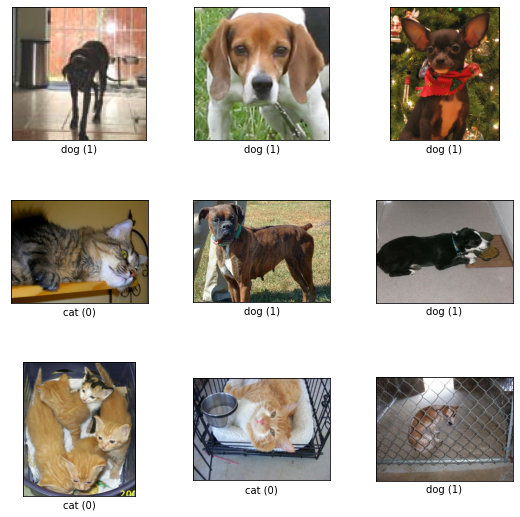

In [17]:
fig = tfds.show_examples(ds_train['cats_vs_dogs'], ds_info['cats_vs_dogs'])

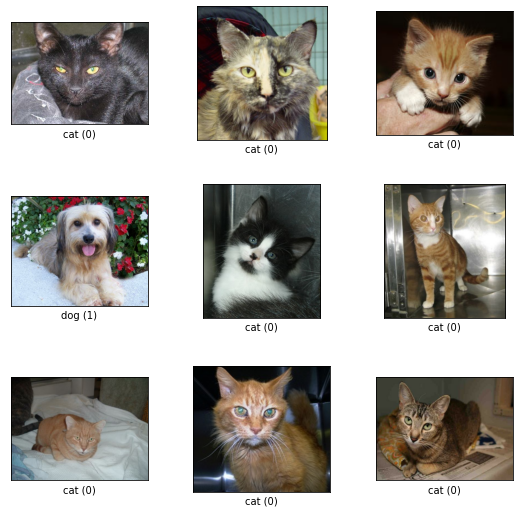

In [18]:
fig = tfds.show_examples(ds_test['cats_vs_dogs'], ds_info['cats_vs_dogs'])

In [19]:
(ds_train['cats_vs_dogs'], ds_test['cats_vs_dogs']), ds_info['cats_vs_dogs'] = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [20]:
ds_train['cats_vs_dogs'] = apply_normalize_on_dataset(ds_train['cats_vs_dogs'], batch_size=BATCH_SIZE)
ds_test['cats_vs_dogs'] = apply_normalize_on_dataset(ds_test['cats_vs_dogs'], batch_size=BATCH_SIZE)

In [21]:
ds_info['cats_vs_dogs'].features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [22]:
ds_info['cats_vs_dogs'].features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

## Plain Net vs ResNet

In [23]:
dataset_input_shape = {'cifar10':32,
                      'cats_vs_dogs':224}
dataset_loss = {'cifar10':'sparse_categorical_crossentropy',
                'cats_vs_dogs':'binary_crossentropy'}

In [24]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=5, verbose=2)

### cifar10

In [31]:
input_size = dataset_input_shape['cifar10']
loss = dataset_loss['cifar10']

input_shape = (input_size,input_size,3)
train, test, info = ds_train['cifar10'], ds_test['cifar10'], ds_info['cifar10']

In [50]:
model = build_resnet(input_shape=input_shape, block_type='plain')
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_236 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_217 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_237 (Bat (None, 8, 8, 64)          256 

In [28]:
resnet_34 = build_resnet(input_shape=input_shape, block_type='residual')
resnet_34.summary()

NameError: name 'conv_bn_relu' is not defined

In [29]:
resnet_34.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-1,  momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    use_multiprocessing=True,
)

NameError: name 'resnet_34' is not defined

In [51]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.9747 - accuracy: 0.2605 - val_loss: 2.9214 - val_accuracy: 0.2826 - lr: 0.0100
Epoch 2/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.6896 - accuracy: 0.3880 - val_loss: 1.9889 - val_accuracy: 0.2690 - lr: 0.0100
Epoch 3/20
1250/1250 [==============================] - 37s 30ms/step - loss: 1.5694 - accuracy: 0.4399 - val_loss: 1.8332 - val_accuracy: 0.3508 - lr: 0.0100
Epoch 4/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.4507 - accuracy: 0.4836 - val_loss: 1.5608 - val_accuracy: 0.4502 - lr: 0.0100
Epoch 5/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.3870 - accuracy: 0.5115 - val_loss: 2.3633 - val_accuracy: 0.2231 - lr: 0.0100
Epoch 6/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.3052 - accuracy: 0.5452 - val_loss: 1.4732 - val_accuracy: 0.5095 - lr: 0.0100
Epoch 7/20
1250/1250 [========================

In [52]:
model = build_resnet(input_shape=input_shape, block_type='plain')
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_272 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_250 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_273 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_273 (Bat (None, 8, 8, 64)          256 

In [53]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.9397 - accuracy: 0.2734 - val_loss: 2.0932 - val_accuracy: 0.2607 - lr: 0.0100
Epoch 2/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.6768 - accuracy: 0.3891 - val_loss: 1.8461 - val_accuracy: 0.4061 - lr: 0.0100
Epoch 3/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.5421 - accuracy: 0.4464 - val_loss: 1.5059 - val_accuracy: 0.4728 - lr: 0.0100
Epoch 4/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.4319 - accuracy: 0.4948 - val_loss: 1.6164 - val_accuracy: 0.4033 - lr: 0.0100
Epoch 5/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.3344 - accuracy: 0.5367 - val_loss: 1.5579 - val_accuracy: 0.4480 - lr: 0.0100
Epoch 6/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.2525 - accuracy: 0.5731 - val_loss: 1.3326 - val_accuracy: 0.5351 - lr: 0.0100
Epoch 7/20
1250/1250 [========================

In [30]:
del resnet_34

NameError: name 'resnet_34' is not defined

In [54]:
model = build_resnet(input_shape=input_shape, block_type='bottleneck')
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_308 (Conv2D)             (None, 16, 16, 64)   9472        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_308 (BatchN (None, 16, 16, 64)   256         conv2d_308[0][0]                 
__________________________________________________________________________________________________
re_lu_283 (ReLU)                (None, 16, 16, 64)   0           batch_normalization_308[0][0]    
____________________________________________________________________________________________

In [55]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1250/1250 [==============================] - 45s 36ms/step - loss: 2.1863 - accuracy: 0.3263 - val_loss: 1.9254 - val_accuracy: 0.3327 - lr: 0.0100
Epoch 2/20
1250/1250 [==============================] - 44s 35ms/step - loss: 1.6721 - accuracy: 0.5045 - val_loss: 1.9446 - val_accuracy: 0.3539 - lr: 0.0100
Epoch 3/20
1250/1250 [==============================] - 44s 35ms/step - loss: 1.4387 - accuracy: 0.5677 - val_loss: 1.1694 - val_accuracy: 0.6009 - lr: 0.0100
Epoch 4/20
1250/1250 [==============================] - 44s 36ms/step - loss: 1.2284 - accuracy: 0.6268 - val_loss: 1.3602 - val_accuracy: 0.5465 - lr: 0.0100
Epoch 5/20
1250/1250 [==============================] - 44s 36ms/step - loss: 1.0389 - accuracy: 0.6705 - val_loss: 2.9494 - val_accuracy: 0.5317 - lr: 0.0100
Epoch 6/20
1250/1250 [==============================] - 44s 36ms/step - loss: 0.8974 - accuracy: 0.7107 - val_loss: 1.1125 - val_accuracy: 0.6176 - lr: 0.0100
Epoch 7/20
1250/1250 [========================

In [55]:
del plain_34

In [69]:
tf.keras.backend.clear_session()
import gc
gc.collect()

390

In [56]:
model = build_resnet(input_shape=input_shape, block_type='plain')
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_361 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_332 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_362 (Bat (None, 8, 8, 64)          256

In [57]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.9624 - accuracy: 0.2621 - val_loss: 1.9153 - val_accuracy: 0.2769 - lr: 0.0100
Epoch 2/20
1250/1250 [==============================] - 37s 30ms/step - loss: 1.6541 - accuracy: 0.3922 - val_loss: 1.9928 - val_accuracy: 0.3364 - lr: 0.0100
Epoch 3/20
1250/1250 [==============================] - 38s 30ms/step - loss: 1.4807 - accuracy: 0.4707 - val_loss: 1.6895 - val_accuracy: 0.4221 - lr: 0.0100
Epoch 4/20
1250/1250 [==============================] - 37s 30ms/step - loss: 1.3557 - accuracy: 0.5142 - val_loss: 1.9523 - val_accuracy: 0.3453 - lr: 0.0100
Epoch 5/20
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2762 - accuracy: 0.5508 - val_loss: 1.5797 - val_accuracy: 0.4331 - lr: 0.0100
Epoch 6/20
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2011 - accuracy: 0.5801 - val_loss: 1.3220 - val_accuracy: 0.5223 - lr: 0.0100
Epoch 7/20
1250/1250 [========================

In [ ]:
del plain_50

#### training loss

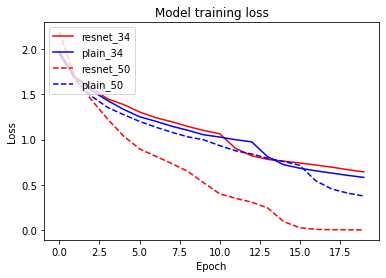

In [58]:
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r--')
plt.plot(history_plain_50.history['loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34','resnet_50', 'plain_50'], loc='upper left')
plt.show()

- resnet34 vs plain34
    - cifar 10에서는 20 epoch 학습 시, plain 모델의 train_loss 감소가 더 잘 되는 것을 알 수 있었다.
- resnet50 vs plain50
    - cifar 10에서는 20 epoch 학습 시, resnet 모델의 train_loss 감소가 더 잘 되는 것을 알 수 있었다.

#### validation accuracy

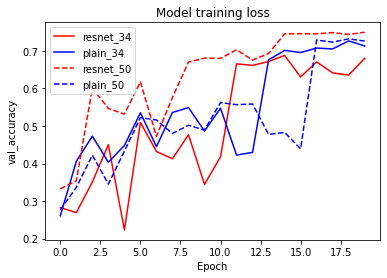

In [60]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r--')
plt.plot(history_plain_50.history['val_accuracy'], 'b--')
plt.title('Model training loss')
plt.ylabel('val_accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34','resnet_50', 'plain_50'], loc='upper left')
plt.show()

- resnet34 vs plain34
    - cifar 10에서는 20 epoch 학습 시, plain 모델의 val_acc가 더 높았다.
- resnet50 vs plain50
    - cifar 10에서는 20 epoch 학습 시, resnet 모델의 val_acc가 더 높았다.

In [66]:
import gc
from keras import backend as K
K.clear_session()
del model
del history_resnet_34
del history_plain_34
del history_resnet_50
del history_plain_50

### cats_vs_dogs

In [25]:
input_size = dataset_input_shape['cats_vs_dogs']
loss = dataset_loss['cats_vs_dogs']

input_shape = (input_size,input_size,3)

train, test, info = ds_train['cats_vs_dogs'], ds_test['cats_vs_dogs'], ds_info['cats_vs_dogs']

In [26]:
model = build_resnet(input_shape=input_shape, num_classes=1, block_type='residual')

In [27]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2,  momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 112s 192ms/step - loss: 0.6663 - accuracy: 0.6370 - val_loss: 2.1136 - val_accuracy: 0.5075 - lr: 0.0100
Epoch 2/20
581/581 [==============================] - 100s 173ms/step - loss: 0.4886 - accuracy: 0.7688 - val_loss: 0.5237 - val_accuracy: 0.7541 - lr: 0.0100
Epoch 3/20
581/581 [==============================] - 90s 154ms/step - loss: 0.3649 - accuracy: 0.8398 - val_loss: 0.5843 - val_accuracy: 0.7108 - lr: 0.0100
Epoch 4/20
581/581 [==============================] - 90s 154ms/step - loss: 0.2844 - accuracy: 0.8812 - val_loss: 1.1509 - val_accuracy: 0.7424 - lr: 0.0100
Epoch 5/20
581/581 [==============================] - 89s 152ms/step - loss: 0.2117 - accuracy: 0.9146 - val_loss: 0.7290 - val_accuracy: 0.6600 - lr: 0.0100
Epoch 6/20
581/581 [==============================] - 89s 153ms/step - loss: 0.1516 - accuracy: 0.9410 - val_loss: 0.3798 - val_accuracy: 0.8394 - lr: 0.0100
Epoch 7/20
581/581 [==============================

In [30]:
if not os.path.exists('history_resnet_34.pkl'):
    with open('history_resnet_34.pkl', 'wb') as f:
        pickle.dump([history_resnet_34], f)
del history_resnet_34

In [31]:
model = build_resnet(input_shape=input_shape, num_classes=1, block_type='plain')

In [ ]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 85s 145ms/step - loss: 0.6816 - accuracy: 0.5751 - val_loss: 1.4192 - val_accuracy: 0.5582 - lr: 0.0100
Epoch 2/20
581/581 [==============================] - 85s 146ms/step - loss: 0.6193 - accuracy: 0.6574 - val_loss: 0.6346 - val_accuracy: 0.6440 - lr: 0.0100
Epoch 3/20
581/581 [==============================] - 85s 147ms/step - loss: 0.5361 - accuracy: 0.7324 - val_loss: 0.7788 - val_accuracy: 0.6583 - lr: 0.0100
Epoch 4/20
581/581 [==============================] - 87s 149ms/step - loss: 0.4622 - accuracy: 0.7857 - val_loss: 0.6553 - val_accuracy: 0.7013 - lr: 0.0100
Epoch 5/20
581/581 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8224

In [ ]:
if not os.path.exists('history_plain_34.pkl'):
    with open('history_plain_34.pkl', 'wb') as f:
        pickle.dump([history_plain_34], f)
del history_plain_34

In [ ]:
model = build_resnet(input_shape=input_shape, num_classes=1, block_type='bottleneck')

In [ ]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

In [ ]:
if not os.path.exists('history_resnet_50.pkl'):
    with open('history_resnet_50.pkl', 'wb') as f:
        pickle.dump([history_resnet_50], f)
del history_resnet_50

In [ ]:
model = build_resnet(input_shape=input_shape, num_classes=1, block_type='plain')

In [ ]:
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = model.fit(
    train,
    steps_per_epoch=int(info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

In [ ]:
if not os.path.exists('history_plain_50.pkl'):
    with open('history_plain_50.pkl', 'wb') as f:
        pickle.dump([history_resnet_50], f)
del history_resnet_50

In [ ]:
K.clear_session()
del model, ds_train, ds_test, ds_info

#### train_loss

In [ ]:
history_resnet_34 = pickle.load(open('history_resnet_34.pkl', 'rb'))[-1]
history_plain_34 = pickle.load(open('history_plain_34.pkl', 'rb'))[-1]
history_resnet_50 = pickle.load(open('history_resnet_50.pkl', 'rb'))[-1]
history_plain_50 = pickle.load(open('history_plain_50.pkl', 'rb'))[-1]

In [ ]:
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r--')
plt.plot(history_plain_50.history['loss'], 'b--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34','resnet_50', 'plain_50'], loc='upper left')
plt.show()

#### val_acc

In [ ]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r--')
plt.plot(history_plain_50.history['val_accuracy'], 'b--')
plt.title('Model training loss')
plt.ylabel('val_accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34','resnet_50', 'plain_50'], loc='upper left')
plt.show()

In [ ]:
K.clear_session()
del model
del history_resnet_34
del history_plain_34
del history_resnet_50
del history_plain_50

## 결론

- cats vs dogs 데이터셋을 이용한 실험은 실패 (메모리 제어 실패)
- cifar10 데이터셋은 '20 epoch' 학습을 한 경우
    - plain-34가 resnet-34보다 학습이 잘 되었으며
    - resnet-50가 plain-50보다 학습이 잘 되었다.

### [Cifar 10] Resnet Ablation Study
|layers|Plain|Resnet|
|---|---|---|
|34|0.7132|0.6804|
|50|0.7263|0.7498|

### [Cats vs Dogs] Resnet Ablation Study
|layers|Plain|Resnet|
|---|---|---|
|34|-|0.9186|
|50|-|-|